# Imports

In [46]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import statsmodels.api as sm

# 1. Analyse du dataset

**Charger les données**

In [3]:
data = pd.read_csv('./Data/coffee-prices-historical-data.csv')
print(data.shape)
data.head()

(12542, 2)


,date,value
0,1973-08-20,0.6735
1,1973-08-21,0.6710
2,1973-08-22,0.6580
3,1973-08-23,0.6675
4,1973-08-24,0.6660


**Nettoyage**

In [4]:
#Valeur nulles ?
data.isnull().sum()
#Pas de valeur nulles

# La colonne date doit être au format datetime
data['date'] = pd.to_datetime(data['date'], format='%Y-%m-%d')

# Colonne dans variables
coffe_price = data['value'].to_numpy()
date = data['date']

**Plot de la serie**

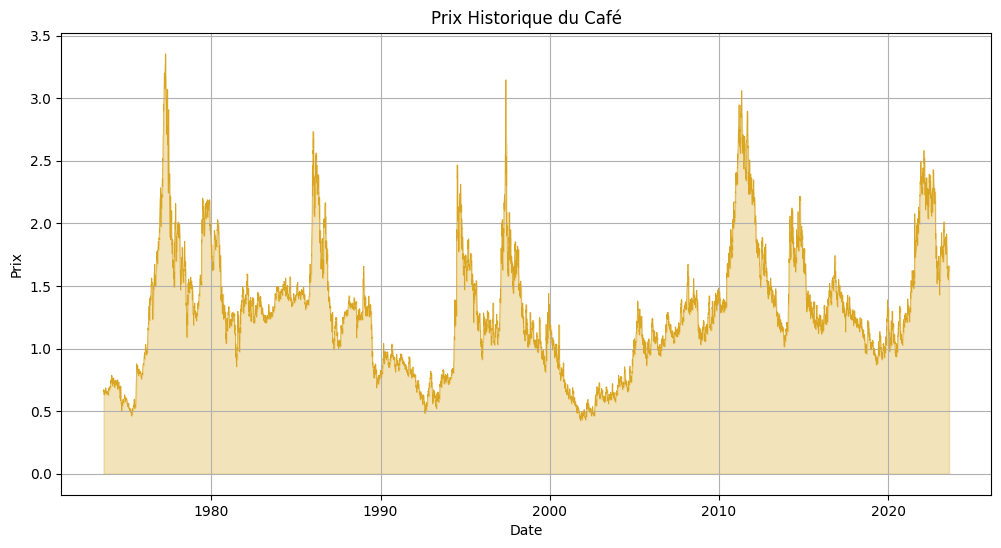

In [5]:
plt.figure(figsize=(12, 6))
plt.plot(date, coffe_price, color='goldenrod', linewidth=0.5)
plt.fill_between(date, coffe_price, color='goldenrod', alpha=0.3)
plt.title('Prix Historique du Café')
plt.xlabel('Date')
plt.ylabel('Prix')
plt.grid(True)
plt.show()

# 2. Stationnariser la série
$$
\text{ On pose }P_t = \text{ Prix cafe à l'instant t}
$$
Une série stationnaire a des statistiques (moyenne, variance) constantes dans le temps et n’exhibe pas de tendance structurelle.

Pour tester la stationnarité, on utilise souvent :

- L’ADF test (Augmented Dickey-Fuller),

- L’observation visuelle (recherche d’une tendance manifeste),

- ACF / PACF (fonctions d’auto-corrélation).

## a) Test ADF
On peut faire le test ADF avec statsmodels :


Si la p-value est inférieure à un seuil (ex. 0.05), on rejette l’hypothèse nulle de non-stationnarité → la série est considérée comme stationnaire.

Si la p-value est élevée, la série est probablement non stationnaire, et on doit la stationnariser.

In [6]:
result = adfuller(coffe_price, autolag='AIC')
adf_stat = result[0]
p_value = result[1]

print(f"ADF Statistic: {adf_stat}")
print(f"p-value: {p_value}")


ADF Statistic: -3.6453065546511785
p-value: 0.004951652434990588


Cet indicateur semble nous affirmer que la série est stationnaire. A voir plus en détail

## b) Différenciation
Le moyen le plus courant de stationnariser une série qui présente une tendance (ou une non-stationnarité) est la différenciation :

$$
\text{ On pose }X_t  = P_t - P_{t-1}$$
​

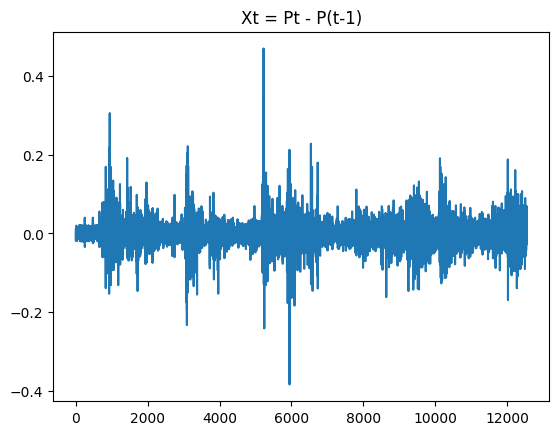

ADF Statistic: -18.1211053956385
p-value: 2.521449825302577e-30


In [51]:
# Calcul de la différence
data['value_diff'] = data['value'].diff()

# Suppression des NaN et des valeurs infinies
data = data.dropna(subset=['value_diff'])  # Supprime les lignes avec NaN dans 'value_diff'

# Visualisation
plt.figure()
plt.plot(data['value_diff'])
plt.title("Xt = Pt - P(t-1)")
plt.show()

# Test ADF
result = adfuller(data['value_diff'], autolag='AIC')
adf_stat = result[0]
p_value = result[1]

print(f"ADF Statistic: {adf_stat}")
print(f"p-value: {p_value}")

**Les résultats semblent encore meilleurs**


Remarque : Parfois, on peut avoir besoin de transformer (logarithme, Box-Cox, etc.) avant la différenciation, si la variance n’est pas stable. Mais souvent, la différenciation suffit.

# 3) Modélisation ARMA(p,q)


## a) Choix d’un ARMA ou ARIMA ?
- ARMA(p,q) : on l’emploie si la série est déjà stationnaire.

- ARIMA(p,d,q) : si ta série ne l’est pas, tu peux prendre en compte la différenciation (d=1) directement dans le modèle.

- ARIMA(p,1,q) équivaut plus ou moins à ARMA(p,q) appliqué à la série différenciée.

**Ici, la série est stationnaire après une différenciation (1ère différence). Dans ce cas, on peut rester sur un modèle ARMA en fournissant la série déjà différenciée à l’algo, ou on peut utiliser ARIMA(p,1,q) sur la série brute.**




## b) Identification des paramètres p, q
Pour choisir p et q, on observe souvent :

- **La ACF (Autocorrelation Function) aide à déterminer q.**
- **La PACF (Partial Autocorrelation Function) aide à déterminer p.**


On regarde où la fonction d’auto-corrélation décroche significativement.

Par exemple, si l’ACF montre des décrochages vers le lag 2, on peut suspecter q=2.

Si la PACF décroche vers lag 1, on peut suspecter p=1.

En pratique, on peut aussi tester plusieurs combinaisons de (p,q) et comparer les critères AIC/BIC.



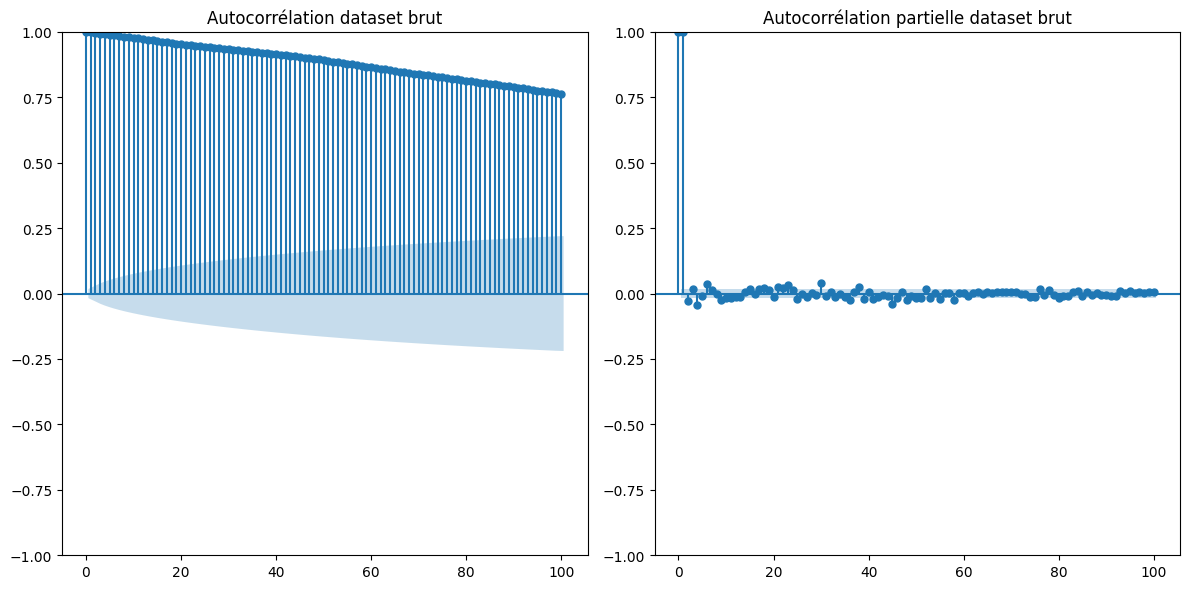

In [ ]:
# Dataset brut pour ACF et PACF
h = 100
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plot_acf(data['value'], lags=h, ax=plt.gca())
plt.title('Autocorrélation dataset brut')
plt.legend([f'h = {h}'])

plt.subplot(1, 2, 2)
plot_pacf(data['value'], lags=h, ax=plt.gca())
plt.title('Autocorrélation partielle dataset brut')
plt.legend([f'h = {h}'])

plt.tight_layout()
plt.show()

Pas de décrochage d'ACF

Décrochage PACF a p = 2

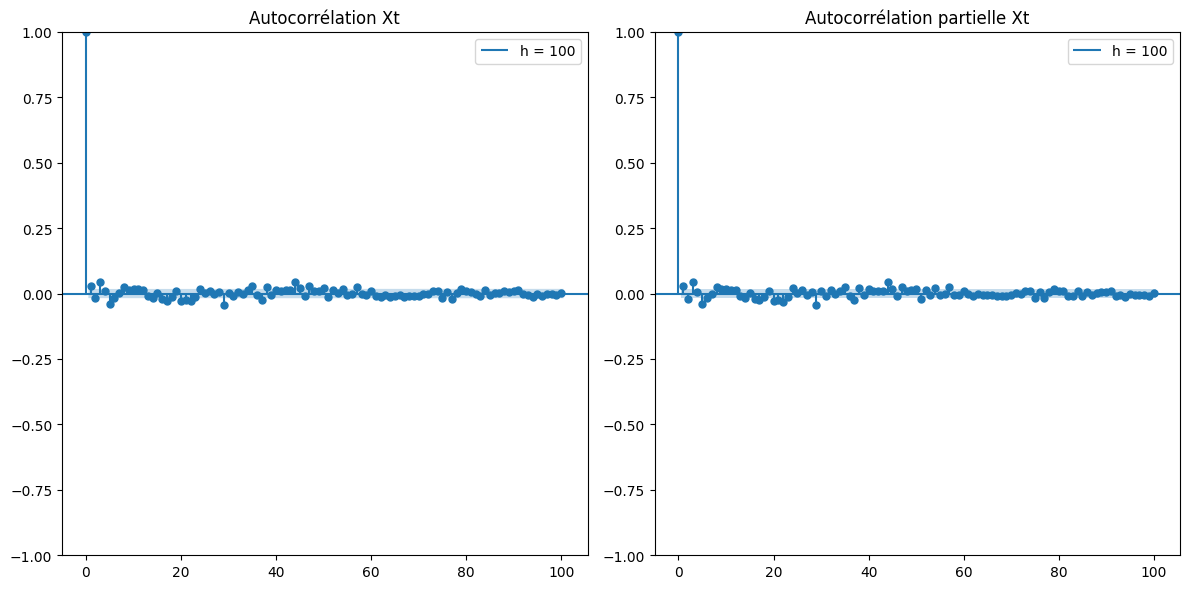

In [52]:
# Xt pour ACF et PACF
h = 100
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plot_acf(data['value_diff'], lags=h, ax=plt.gca())
plt.title('Autocorrélation Xt')
plt.legend([f'h = {h}'])

plt.subplot(1, 2, 2)
plot_pacf(data['value_diff'], lags=h, ax=plt.gca())
plt.title('Autocorrélation partielle Xt')
plt.legend([f'h = {h}'])

plt.tight_layout()
plt.show()

Décrochage à p = q = 1

## c) Estimation ARMA(p,q)
Pour la partie code, statsmodels propose plusieurs approches. La plus simple (pour un usage direct) est d’utiliser ARIMA en précisant order=(p,0,q) si la série est déjà stationnaire :

Important :

Pour un ARMA(p,q) sur la série déjà différenciée, tu mets d=0 dans l’ARIMA, puisque la différenciation est déjà faite avant.

Si tu veux directement appliquer la différenciation dans le modèle, tu utiliserais ARIMA(df['valeur'], order=(p,1,q)).

Le résumé (results.summary()) fournit beaucoup d’informations, notamment les coefficients estimés, les tests de significativité, et les critères AIC/BIC.



In [48]:
p, d, q = 1, 0, 1  # Exemple : ARMA(1,1)
model = sm.tsa.ARIMA(data['value_diff'], order=(p,d,q))  
results = model.fit()

print(results.summary())


C:\Users\tapri\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
C:\Users\tapri\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
C:\Users\tapri\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, foreca

                               SARIMAX Results                                
Dep. Variable:             value_diff   No. Observations:                12540
Model:                 ARIMA(1, 0, 1)   Log Likelihood               25518.589
Date:                Sun, 30 Mar 2025   AIC                         -51029.178
Time:                        22:51:54   BIC                         -50999.431
Sample:                             0   HQIC                        -51019.221
                              - 12540                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       7.006e-05      0.000      0.240      0.811      -0.001       0.001
ar.L1          0.0147      0.153      0.096      0.923      -0.285       0.314
ma.L1          0.0147      0.153      0.096      0.9

# 4 Prévision (forecasting)
Une fois ton modèle ajusté, tu peux faire de la prévision. Par exemple, pour prévoir les 30 points (dates) suivants :

python
Copier
Modifier
forecast_steps = 30
forecast = results.forecast(steps=forecast_steps)
print(forecast)
Cela renvoie :

La prévision ponctuelle (mean)

L’intervalle de confiance (confidence intervals)

Si tu as fait l’estimation sur la série différenciée (valeur_diff), les prévisions retournées seront en différence. Pour retrouver la valeur brute, il faut ensuite re-cumuler les différences. Par exemple :




Exemple complet de code d’enchaînement
Voici un exemple qui illustre le “flow” complet (en supposant qu’une seule différenciation est suffisante pour la stationnarisation). À adapter selon tes données.












In [7]:
# forecast = array des prédictions pour la différence
# Tu as besoin de la dernière valeur "réelle" pour reconstruire :

last_known_value = df['valeur'].iloc[-1]
predictions_cumsum = forecast.cumsum()  # on cumule les différences
predicted_values = last_known_value + predictions_cumsum

#Et tu obtiens enfin des valeurs prédites comparables à tes données d’origine (prix du café).

NameError: name 'df' is not defined

In [ ]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# 1) Chargement des données
df = pd.read_csv('prix_cafe.csv', parse_dates=['date'], index_col='date')

# 2) Visualisation
plt.figure()
plt.plot(df['valeur'])
plt.title("Prix du café au fil du temps")
plt.show()

# 3) Test ADF sur la série brute
result = adfuller(df['valeur'].dropna(), autolag='AIC')
print("p-value ADF (série brute) =", result[1])

# 4) Stationnarisation par différenciation (si nécessaire)
df['valeur_diff'] = df['valeur'].diff()
df.dropna(inplace=True)

# Nouveau test ADF
result_diff = adfuller(df['valeur_diff'], autolag='AIC')
print("p-value ADF (série différenciée) =", result_diff[1])

# 5) Identification visuelle de p,q via ACF/PACF
plot_acf(df['valeur_diff'], lags=30)
plt.show()
plot_pacf(df['valeur_diff'], lags=30)
plt.show()

# 6) Modèle ARMA(p,q) sur la série différenciée => ARIMA(p,0,q)
# Adapte p,q après analyse de l'ACF/PACF
p, d, q = 1, 0, 1
model = sm.tsa.ARIMA(df['valeur_diff'], order=(p,d,q))
results = model.fit()
print(results.summary())

# 7) Prévision
forecast_steps = 30
forecast_diff = results.forecast(steps=forecast_steps)[0]  # vecteur
last_known_value = df['valeur'].iloc[-1]
predictions_cumsum = forecast_diff.cumsum()
predicted_values = last_known_value + predictions_cumsum

# 8) Visualisation des prévisions
# Créons un index de dates futur
last_date = df.index[-1]
future_dates = pd.date_range(start=last_date, periods=forecast_steps+1, freq='D')[1:]

pred_df = pd.DataFrame({
    'forecast_diff': forecast_diff,
    'predicted_values': predicted_values
}, index=future_dates)

plt.figure()
plt.plot(df['valeur'], label='Historique')
plt.plot(pred_df['predicted_values'], label='Prévisions')
plt.title("Prévisions ARMA(1,1) sur 30 jours")
plt.legend()
plt.show()



# Conseils supplémentaires
Validation croisée ou séparation train/test : Pour mieux évaluer la performance, sépare une partie finale de tes données comme “jeu de test”. Ajuste le modèle sur le “jeu d’entraînement” seulement, puis compare les prédictions avec le “jeu de test” réel.

Hyperparamètres (p, q) :

Il existe des méthodes automatiques pour chercher la meilleure combinaison (p,q,d) selon AIC/BIC, par exemple pmdarima.arima.auto_arima.

Toutefois, comprendre l’ACF/PACF reste formateur.

Diagnostic des résidus :

Après l’ajustement, vérifie l’ACF des résidus pour t’assurer qu’il ne reste pas de forte autocorrélation.

Un bon modèle doit laisser des résidus “blancs”.

Saisonnalité :

Si tu détectes une saisonnalité (hebdomadaire, mensuelle...), tu peux envisager un modèle SARIMA (ARIMA saisonnier), spécifiant (P,D,Q,m), où m est la période de saisonnalité.

Visualisations :

Tracer l’évolution de la série, la série différenciée, les ACF/PACF, et le comparatif prévisions vs valeurs réelles sont essentiels pour le rapport.

En suivant ces étapes, tu couvres les attendus du projet :

Stationnariser la série,

Modéliser (ARMA ou ARIMA) et estimer les paramètres,

Prévoir sur des horizons futurs (et valider la pertinence du modèle).

N’hésite pas à ajuster les valeurs de p, q (et d) pour trouver la meilleure performance selon tes critères (AIC, BIC, RMSE). Bon courage pour ton projet !

